In [20]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import random

In [ ]:
def enhance_brain_contrast(preprocessed_img_path, brain_mask_path, output_dir, clipLimit=2.0, tileGridSize=(8, 8)):
    """
    Applies CLAHE to the brain region of a preprocessed image using a skull-stripped mask.

    Args:
        preprocessed_img_path (str): Path to the preprocessed grayscale image (from Module 1).
        brain_mask_path (str): Path to the corresponding skull-stripped binary brain mask (from Module 2).
        output_dir (str): Directory to save the CLAHE enhanced brain image.
        clipLimit (float): Threshold for contrast limiting in CLAHE.
        tileGridSize (tuple): Size of grid for histogram equalization in CLAHE.
    """
    try:
        # Load the preprocessed image (grayscale)
        img = cv2.imread(preprocessed_img_path, 0)
        if img is None:
            print(f"Warning: Could not read preprocessed image {preprocessed_img_path}. Skipping.")
            return

        # Load the brain mask (grayscale)
        mask = cv2.imread(brain_mask_path, 0)
        if mask is None:
            print(f"Warning: Could not read brain mask {brain_mask_path}. Skipping enhancement for {preprocessed_img_path}.")
            return

        # Ensure mask is binary (0 or 255) in case it's not already
        _, mask_binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

        # Isolate the brain region from the preprocessed image using the mask [cite: team_guide.md]
        brain_only = cv2.bitwise_and(img, img, mask=mask_binary)

        # Apply CLAHE only to the brain region (pixels outside the mask are 0) [cite: 6_Histogram equalization.pdf]
        clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
        enhanced_brain = clahe.apply(brain_only)

        # Pixels outside the mask might have been slightly affected by interpolation,
        # apply the mask again to ensure the background is perfectly black.
        enhanced_brain_masked = cv2.bitwise_and(enhanced_brain, enhanced_brain, mask=mask_binary)

        # Save the result
        base_filename = os.path.basename(preprocessed_img_path)
        output_filename = base_filename.replace('.png', '_clahe.png')
        output_path = os.path.join(output_dir, output_filename)
        cv2.imwrite(output_path, enhanced_brain_masked)

    except Exception as e:
        print(f"Error processing {preprocessed_img_path} with mask {brain_mask_path}: {e}")

In [ ]:
preprocessed_base_dir = '/content/drive/MyDrive/processed_images'
# Directory containing Module 2 output (skull-stripped masks from Vamsi/GitHub)
mask_base_dir = '/content/drive/MyDrive/skull_stripped_masks'
# Directory where Module 3 output (CLAHE enhanced images) will be saved
output_base_dir = '/content/drive/MyDrive/clahe_enhanced_brains'

tumor_types = ['Meningioma', 'Glioma', 'Pituitary tumor'] # Match your folder names

In [5]:
for tumor_type in tumor_types:
    preprocessed_dir = os.path.join(preprocessed_base_dir, tumor_type)
    mask_dir = os.path.join(mask_base_dir, tumor_type)
    output_dir = os.path.join(output_base_dir, tumor_type)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")

    # Find all preprocessed image files
    search_pattern = os.path.join(preprocessed_dir, '*.png')
    # Make sure we don't accidentally process masks if they exist in this folder
    preprocessed_paths = [p for p in glob.glob(search_pattern) if '_mask' not in p]

    print(f"\n--- Processing {tumor_type} images ---")
    processed_count = 0
    skipped_count = 0
    for img_path in preprocessed_paths:
        base_filename = os.path.basename(img_path)
        # Construct the expected mask filename based on Module 2's output naming convention
        mask_filename = base_filename.replace('.png', '_brain_mask.png')
        mask_path = os.path.join(mask_dir, mask_filename)

        if os.path.exists(mask_path):
            enhance_brain_contrast(img_path, mask_path, output_dir)
            processed_count += 1
        else:
            print(f"  Mask not found for {base_filename} at {mask_path}, skipping.")
            skipped_count += 1

    print(f"Finished {tumor_type}: Processed {processed_count}, Skipped {skipped_count}")

print("\n✅ Module 3 (CLAHE Enhancement) complete.")

Created directory: /content/drive/MyDrive/clahe_enhanced_brains/Meningioma

--- Processing Meningioma images ---
Finished Meningioma: Processed 708, Skipped 0
Created directory: /content/drive/MyDrive/clahe_enhanced_brains/Glioma

--- Processing Glioma images ---
Finished Glioma: Processed 1426, Skipped 0
Created directory: /content/drive/MyDrive/clahe_enhanced_brains/Pituitary tumor

--- Processing Pituitary tumor images ---
Finished Pituitary tumor: Processed 930, Skipped 0

✅ Module 3 (CLAHE Enhancement) complete.


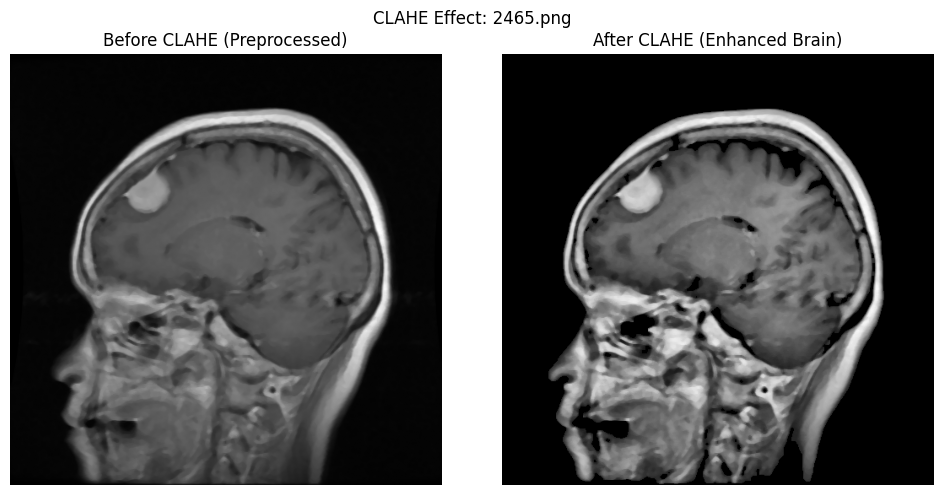

In [12]:
# --- Optional: Display one example ---
# (You can reuse/adapt the visualization part from the full pipeline code if needed)
# Example:
try:
    example_type = 'Glioma' # Choose a type
    # Find an example image name from the processed files
    example_dir = os.path.join(output_base_dir, example_type)
    clahe_files = glob.glob(os.path.join(example_dir, '*_clahe.png'))

    if not clahe_files:
        print(f"No CLAHE enhanced images found for {example_type} to display example.")
    else:
        # Pick the first CLAHE file found
        example_clahe_path = clahe_files[0]
        example_clahe_name = os.path.basename(example_clahe_path)

        # Derive the original preprocessed image name
        example_img_name = example_clahe_name.replace('_clahe.png', '.png')
        orig_preprocessed_path = os.path.join(preprocessed_base_dir, example_type, example_img_name)

        img_before = cv2.imread(orig_preprocessed_path, 0)
        img_after = cv2.imread(example_clahe_path, 0)

        if img_before is not None and img_after is not None:
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(img_before, cmap='gray')
            axes[0].set_title('Before CLAHE (Preprocessed)')
            axes[0].axis('off')
            axes[1].imshow(img_after, cmap='gray')
            axes[1].set_title('After CLAHE (Enhanced Brain)')
            axes[1].axis('off')
            plt.suptitle(f"CLAHE Effect: {example_img_name}")
            plt.tight_layout()
            plt.show()
        else:
            print(f"Could not read image files for {example_img_name} or its CLAHE counterpart.")

except Exception as e:
    print(f"Could not generate example visualization: {e}")

In [22]:
preprocessed_base_dir = '/content/drive/MyDrive/processed_images'
mask_base_dir = '/content/drive/MyDrive/skull_stripped_masks'
clahe_base_dir = '/content/drive/MyDrive/clahe_enhanced_brains' # Renamed for clarity
tumor_types = ['Meningioma', 'Glioma', 'Pituitary tumor']

def visualize_stages(original_preprocessed_path, skull_mask_path, clahe_enhanced_path):
    """Loads and displays the three image stages side-by-side."""

    # Load images in grayscale
    img_preprocessed = cv2.imread(original_preprocessed_path, 0)
    img_skull_mask = cv2.imread(skull_mask_path, 0)
    img_clahe = cv2.imread(clahe_enhanced_path, 0)

    # Check if all images loaded correctly
    if img_preprocessed is None or img_skull_mask is None or img_clahe is None:
        print("Error: Could not load one or more images. Check paths:")
        if img_preprocessed is None: print(f"  Failed: {original_preprocessed_path}")
        if img_skull_mask is None: print(f"  Failed: {skull_mask_path}")
        if img_clahe is None: print(f"  Failed: {clahe_enhanced_path}")
        return

    # Create the plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 1 row, 3 columns

    axes[0].imshow(img_preprocessed, cmap='gray')
    axes[0].set_title('1. Preprocessed (Median Filter)')
    axes[0].axis('off')

    axes[1].imshow(img_skull_mask, cmap='gray')
    axes[1].set_title('2. Skull-Stripped Mask')
    axes[1].axis('off')

    axes[2].imshow(img_clahe, cmap='gray')
    axes[2].set_title('3. CLAHE Enhanced Brain')
    axes[2].axis('off')

    # Add an overall title with the base filename
    base_filename = os.path.basename(original_preprocessed_path)
    plt.suptitle(f'Processing Stages for: {base_filename}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    plt.show()

Generating visualizations...

Visualizing example for Meningioma...
  Displaying: 517.png


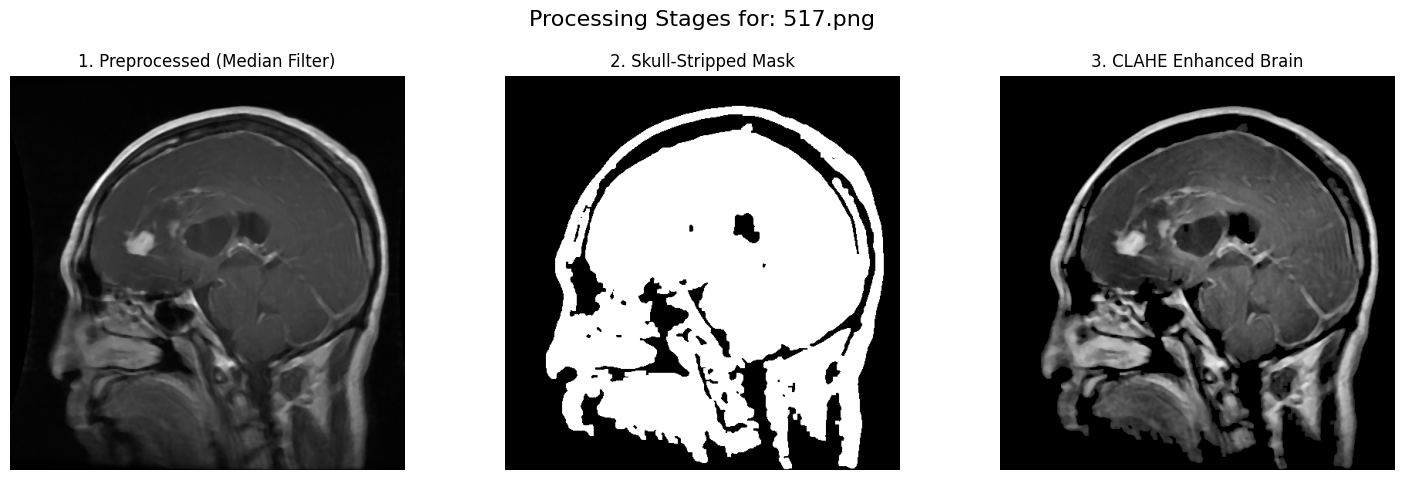


Visualizing example for Glioma...
  Displaying: 1983.png


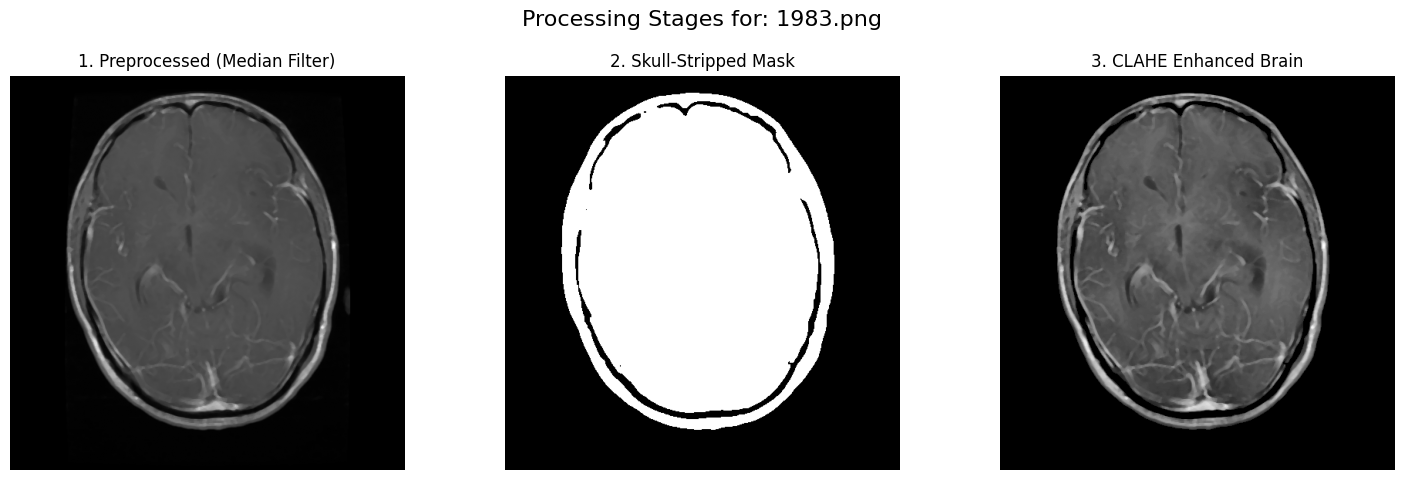


Visualizing example for Pituitary tumor...
  Displaying: 1038.png


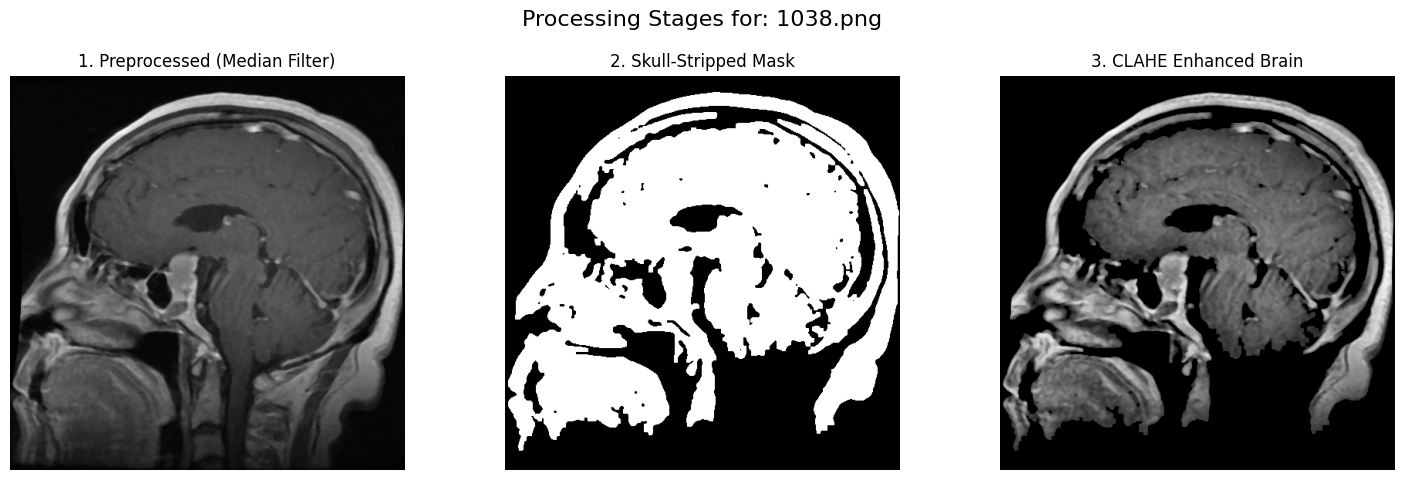


--- Visualization finished ---


In [23]:
print("Generating visualizations...")
for tumor_type in tumor_types:
    print(f"\nVisualizing example for {tumor_type}...")

    # --- Explicitly define directories for the CURRENT tumor type ---
    current_preprocessed_dir = os.path.join(preprocessed_base_dir, tumor_type)
    current_mask_dir = os.path.join(mask_base_dir, tumor_type)
    current_clahe_dir = os.path.join(clahe_base_dir, tumor_type)

    # Find all preprocessed images in the current preprocessed directory
    search_pattern = os.path.join(current_preprocessed_dir, '*.png')
    preprocessed_files = [p for p in glob.glob(search_pattern) if '_mask' not in p and '_clahe' not in p and '_brain_mask' not in p]

    if not preprocessed_files:
        print(f"  No preprocessed images found in {current_preprocessed_dir}. Skipping.")
        continue

    # Pick a random image file from the current directory
    random_img_path = random.choice(preprocessed_files)
    base_filename = os.path.basename(random_img_path)

    # --- Construct full paths using the CORRECT directories for the current tumor type ---
    skull_mask_filename = base_filename.replace('.png', '_brain_mask.png')
    skull_mask_path = os.path.join(current_mask_dir, skull_mask_filename) # Use current_mask_dir

    clahe_filename = base_filename.replace('.png', '_clahe.png')
    clahe_enhanced_path = os.path.join(current_clahe_dir, clahe_filename) # Use current_clahe_dir

    # Check if all corresponding files exist before trying to visualize
    if os.path.exists(random_img_path) and os.path.exists(skull_mask_path) and os.path.exists(clahe_enhanced_path):
        print(f"  Displaying: {base_filename}")
        visualize_stages(random_img_path, skull_mask_path, clahe_enhanced_path)
    else:
        print(f"  Skipping visualization for {base_filename}: Corresponding file(s) not found.")
        # Print expected paths for debugging
        if not os.path.exists(random_img_path): print(f"    Missing Preprocessed Check: {random_img_path}") # Should exist
        if not os.path.exists(skull_mask_path): print(f"    Expected Skull Mask at: {skull_mask_path}")
        if not os.path.exists(clahe_enhanced_path): print(f"    Expected CLAHE Image at: {clahe_enhanced_path}")

print("\n--- Visualization finished ---")

In [14]:
!zip -r /content/clahe_enhanced_brains.zip /content/drive/MyDrive/clahe_enhanced_brains

  adding: content/drive/MyDrive/clahe_enhanced_brains/ (stored 0%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/ (stored 0%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/677_clahe.png (deflated 0%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/584_clahe.png (deflated 0%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/90_clahe.png (deflated 1%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/684_clahe.png (deflated 1%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/685_clahe.png (deflated 1%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/608_clahe.png (deflated 1%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/556_clahe.png (deflated 0%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/600_clahe.png (deflated 1%)
  adding: content/drive/MyDrive/clahe_enhanced_brains/Meningioma/576_clahe.png (deflated 0%)
  adding: content/d